In [23]:
from scipy.sparse.linalg import eigs
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/PECAN/pecan")
from ripser import Ripser
from kernels import get_kernel_fn, alpha_decaying_kernel
from sklearn.decomposition import PCA


def diffusion_map(P, dim=10, tolerance=1e-10):
    """
    P the diffusion operator (D^{-1}K)
    or L to make sure the eigenvectors are real-valued.
    dim the dim of the diffusion map (number of eigenvectors)
    """
    # Find the 2 largest eigenvalues and their corresponding eigenvectors
    eigenvalues, eigenvectors = eigs(P, k=dim, which='LM')
    return check_real(eigenvalues, tolerance), check_real(eigenvectors, tolerance)
    # return check_real(eigenvalues * eigenvectors, tolerance)

def check_real(array, tolerance=1e-10):
    """
    Efficiently checks if all elements in a 2D array are real within a specified tolerance.
    Returns a new array with the real parts of the elements if they are real.
    
    Parameters:
        array (numpy.ndarray): 2D array to check.
        tolerance (float): The tolerance within which the imaginary part should be zero.
    
    Returns:
        numpy.ndarray: A new array containing the real parts of the elements.
    
    Raises:
        ValueError: If any element in the array is not real within the specified tolerance.
    """
    
    # Check if all elements are real within the tolerance
    if np.all(np.abs(array.imag) <= tolerance):
        return array.real
    else:
        raise ValueError("Some elements in the array are not real within the specified tolerance.")

def make_diffusion(X, alpha=1, epsilon=1):
    K = alpha_decaying_kernel(X, alpha=alpha, epsilon=epsilon)
    Q = np.sum(K, axis=1)
    P = np.diag(1.0 / Q) @ K
    return P

def visuallize_diffusion_map(X, P, dim=10, tolerance=1e-10, name='Dataset', epsilon=1):
    lam, Xd = diffusion_map(P)
    Xd = lam * Xd
    pca = PCA(n_components=2)
    Xpca = pca.fit_transform(Xd)

    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first dataset on the first subplot
    axs[0].scatter(X[:, 0], X[:, 1])
    axs[0].set_title(name)

    # Plot the second dataset (diffusion map) on the second subplot
    axs[1].scatter(Xpca[:, 0], Xpca[:, 1])
    axs[1].set_title(f'Diffusion Map $\epsilon=${epsilon}')

    plt.show()

In [6]:
"""Data set generator methods."""

import numpy as np


def spiral(N, **kwargs):
    A=1
    omega=1
    phi=0
    t_min=0
    t_max=10
    """
    Generate a dataset of a spiral.

    Parameters:
    - N: Number of points
    - A: Amplitude
    - omega: Angular frequency
    - phi: Phase
    - t_min: Minimum time value
    - t_max: Maximum time value

    Returns:
    - X: 2D array of shape (N, 2), where each row is a point [x(t), y(t)]
    - t: 1D array of time values
    """
    # Generate time values
    t = np.linspace(t_min, t_max, N)
    
    # Generate the spiral points using the parametric equations
    x = A * t * np.cos(omega * t + phi)
    y = A * t * np.sin(omega * t + phi)
    
    # Combine x and y coordinates into a single 2D array
    X = np.column_stack((x, y))
    
    return X, t

def simplex(N, **kwargs):
    """Generate set of equidistant points."""
    X = []
    C = np.linspace(0, 1, N)

    for i in range(N - 1):
        x = np.zeros((N - 1))
        x[i] = 1

        X.append(x)

    # Last point is a little bit icky...
    X.append((np.ones((N - 1)) - np.sqrt(N)) / (N - 1))

    # Make everything uniform and scale distances
    X = np.asarray(X)
    X /= np.sqrt(2)

    return X, C


def blobs(N, **kwargs):
    """Generate set of Gaussian blobs."""
    from sklearn.datasets import make_blobs

    return make_blobs(N, random_state=kwargs["random_state"])


def moons(N, **kwargs):
    """Generate moons data set with labels."""
    from sklearn.datasets import make_moons

    return make_moons(N, random_state=kwargs["random_state"])


def nested_circles(N, **kwargs):
    """Generate nested circles with labels."""
    from sklearn.datasets import make_circles

    return make_circles(N, random_state=kwargs["random_state"])


def barbell(N, beta=1, **kwargs):
    """Generate uniformly-sampled 2-D barbelll with colours."""
    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    X = []
    C = []
    k = 1

    while k <= N:
        x = (2 + beta / 2) * np.random.uniform()
        y = (2 + beta / 2) * np.random.uniform()

        n_prev = len(C)

        if (x - 0.5) ** 2 + (y - 0.5) ** 2 <= 0.25:
            C.append(0)

        elif abs(x - 1 - beta / 4) < beta / 4 and abs(y - 0.5) < 0.125:
            C.append(1)

        elif (x - 1.5 - beta / 2) ** 2 + (y - 0.5) ** 2 <= 0.25:
            C.append(2)

        if len(C) > n_prev:
            X.append((x, y))
            k += 1

    return np.asarray(X), np.asarray(C)


def double_annulus(N, **kwargs):
    """Sample N points from a double annulus."""
    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    X = []
    C = []
    for i in range(N):
        while True:
            t = [np.random.uniform(-50, 50, 1)[0], np.random.uniform(-50, 140, 1)[0]]

            d = np.sqrt(np.dot(t, t))
            if d <= 50 and d >= 20:
                X.append(t)
                C.append(0)
                break

            d = np.sqrt(t[0] ** 2 + (t[1] - 90) ** 2)
            if d <= 50 and d >= 40:
                X.append(t)
                C.append(1)
                break

    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    return np.asarray(X), np.asarray(C)


def annulus(N, r, R, **kwargs):
    """Sample points from annulus.

    This function samples `N` points from an annulus with inner radius `r`
    and outer radius `R`.

    Parameters
    ----------
    N : int
        Number of points to sample

    r : float
        Inner radius of annulus

    R : float
        Outer radius of annulus

    **kwargs:
        Optional keyword arguments, such as a fixed random state for the
        pseudo-random number generator.

    Returns
    -------
    Array of (x, y) coordinates.
    """
    if r >= R:
        raise RuntimeError("Inner radius must be less than or equal to outer radius")

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    thetas = np.random.uniform(0, 2 * np.pi, N)

    # Need to sample based on squared radii to account for density
    # differences.
    radii = np.sqrt(np.random.uniform(r ** 2, R ** 2, N))

    X = np.column_stack((radii * np.cos(thetas), radii * np.sin(thetas)))
    return X, np.linspace(0, 1, N)


def hyperuniform_circle(N, **kwargs):
    """Generate hyperuniformly-Sampled 2-D circle and colours."""
    X = []
    C = np.linspace(0, 1, N)

    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)

    for t in theta:
        X.append((np.cos(t), np.sin(t)))

    return np.asarray(X), np.asarray(C)


def hyperuniform_ellipse(N, a=0.5, b=1, **kwargs):
    """Generate hyperuniformly-sampled 2-D ellipse with colours."""
    # a must be the length of minor semi-axis; b major semi-axis
    assert a < b

    X = []
    C = np.linspace(0, 1, N)

    angles = 2 * np.pi * np.arange(N) / N

    if a != b:
        # Given N points, combine scipy elliptic integral + optimize to
        # find N equidistant points along ellipse manifold, then
        # convert to angles.

        from scipy import special
        from scipy import optimize

        e = np.sqrt(1.0 - a ** 2 / b ** 2)
        tot_size = special.ellipeinc(2.0 * np.pi, e)
        arc_size = tot_size / N
        arcs = np.arange(N) * arc_size
        res = optimize.root(lambda x: (special.ellipeinc(x, e) - arcs), angles)
        angles = res.x

        arcs = special.ellipeinc(angles, e)

    for t in angles:
        X.append((a * np.cos(t), b * np.sin(t)))

    return np.asarray(X), np.asarray(C)


def linked_hyperuniform_circles(N, **kwargs):
    """Generate linked hyperuniformly-sampled 2D circles and colours."""
    X = []
    C = np.linspace(0, 1, N)

    theta = np.linspace(0, 2 * np.pi, N // 2, endpoint=False)
    theta = np.concatenate((theta, theta))

    for i, t in enumerate(theta):
        if i < N // 2:
            X.append((np.cos(t), np.sin(t)))
        # Shift the second circle away so that they are only linked at
        # a single point.
        else:
            X.append((2 + np.cos(t), np.sin(t)))

    return np.asarray(X), np.asarray(C)


def petals(N, **kwargs):
    """Generate petal data set."""
    X = []  # points in respective petals
    Y = []  # auxiliary array (points on outer circle)
    C = []

    assert N > 4, "Require more than four data points"

    # Number of 'petals' to point into the data set. This is required to
    # ensure that the full space is used.
    M = int(np.floor(np.sqrt(N)))
    thetas = np.linspace(0, 2 * np.pi, M, endpoint=False)

    for theta in thetas:
        Y.append(np.asarray([np.cos(theta), np.sin(theta)]))

    # Radius of the smaller cycles is half of the chord distance between
    # two 'consecutive' points on the circle.
    r = 0.5 * np.linalg.norm(Y[0] - Y[1])

    for i, x in enumerate(Y):
        for theta in thetas:
            X.append(np.asarray([r * np.cos(theta) - x[0], r * np.sin(theta) - x[1]]))

            # Indicates that this point belongs to the $i$th circle.
            C.append(i)

    return np.asarray(X), np.asarray(C)


def poisson_process(N, **kwargs):
    """Generate points based on a Poisson process."""
    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    n = np.random.poisson(N)
    X = np.random.rand(n, 2)
    C = np.linspace(0, 1, n)

    return X, C


def const_curvature_disk(N, K, **kwargs):
    """Sample points on manifolds of constant curvature."""

    if np.isclose(K, 0):
        return euclidean_disk(N, **kwargs)
    else:
        return spherical_cap(N, K, **kwargs) if K > 0 else hyperbolic_disk(N, K, **kwargs)


def euclidean_disk(N, **kwargs):
    """Sample points on a unit Euclidean disk."""

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    u = np.random.uniform(0, 1, N)
    r = np.sqrt(u)
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = np.multiply(r, np.cos(theta))
    y = np.multiply(r, np.sin(theta))
    C = np.linspace(0, 1, N)

    return np.vstack([x, y]).T, C


def spherical_cap(N, K, **kwargs):
    """Sample points from a unit disk on the surface of a sphere with const. positive curvature K."""

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    assert K > 0

    u = np.random.uniform(0, 1, N)
    r = np.multiply(np.sqrt(u), np.sin(np.sqrt(K) / 2.0))
    r = np.multiply(2.0 / np.sqrt(K), np.arcsin(r))
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = np.multiply(r, np.cos(theta))
    y = np.multiply(r, np.sin(theta))
    C = np.linspace(0, 1, N)

    return np.vstack([x, y]).T, C


def hyperbolic_disk(N, K, **kwargs):
    """Sample points from a hyperbolic disk (using the Poincaré metric) with const. negative curvature K."""

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    assert K < 0

    u = np.random.uniform(0, 1, N)
    r = np.multiply(np.sqrt(u), np.sinh(np.sqrt(-K) / 2.0))
    r = np.multiply(2.0 / np.sqrt(-K), np.arcsinh(r))
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = np.multiply(r, np.cos(theta))
    y = np.multiply(r, np.sin(theta))
    C = np.linspace(0, 1, N)

    return np.vstack([x, y]).T, C


def torus(N, inner_radius=3, outer_radius=10):
    """Generate n-point hollow torus with one hole."""

    # begin by generating a hollow cylinder
    # from N random uniform points, normalized so that y^2 + z^2 = inner_radius^2
    X = np.random.rand(N, 3) * 2 - 1
    X[:, 1:] /= np.sqrt(np.sum(X[:, 1:] ** 2, axis=1))[:, None] / inner_radius
    x, y, z = X.T
    # Twist the cylinder
    # first, shift the cylinder on the y axis so that 0,0,0 lies at the center of the soon-to-be constructed donut
    rod_length = outer_radius - inner_radius
    y += outer_radius
    # Transform into polar coordinates around Z axis
    r = np.sqrt(x ** 2 + y ** 2)
    theta = (
        x * 2 * np.pi
    )  # we can disregard the previous angle, which didn't mean anything
    # Back to cartesian coords
    x = np.cos(theta) * r
    y = np.sin(theta) * r

    # Recombine the variables
    X = np.column_stack((x, y, z))
    return X, None


def sphere(N, dim=3):
    """Generate N-point sphere with specified dimension. A wrapper for tadasets

    Args:
        N (int): Number of points
        dim (int, optional): Dimension of sphere. Defaults to 3.
    """
    import tadasets

    dsphere = tadasets.dsphere(
        n=N, d=dim - 1, r=1
    )  # TODO: Can also specify the amount of noise to add to the sphere
    return dsphere, None


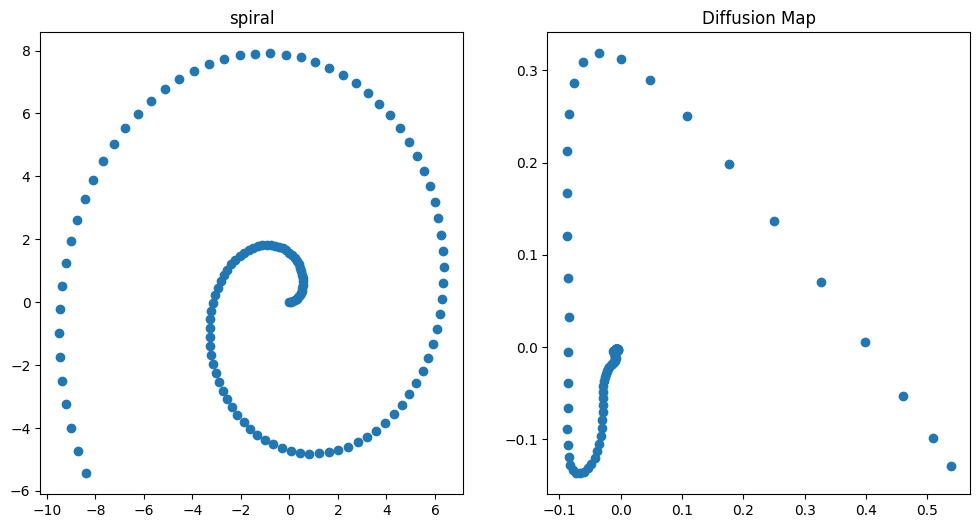

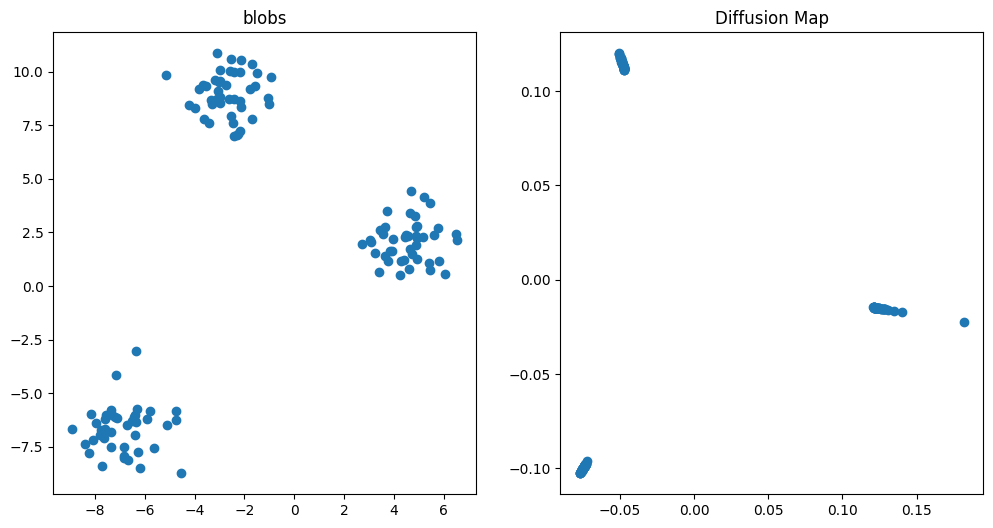

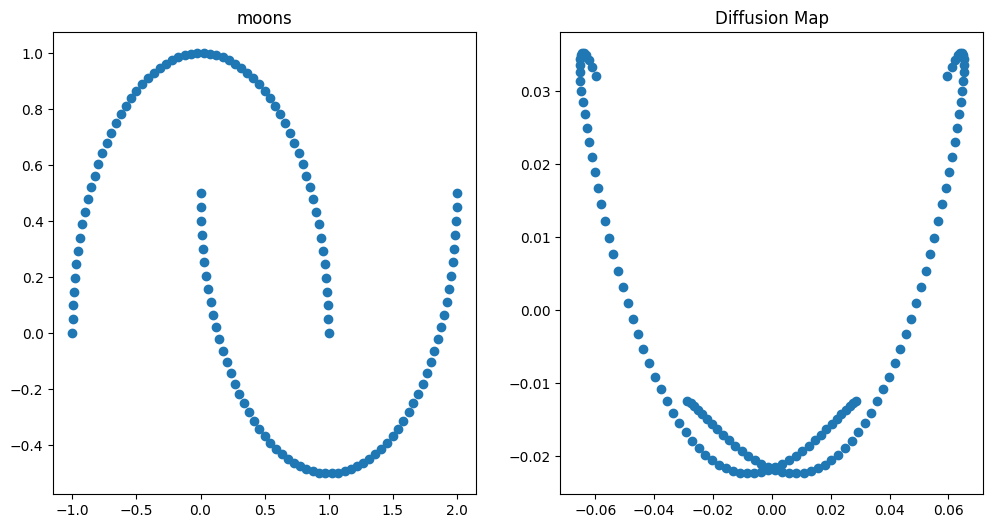

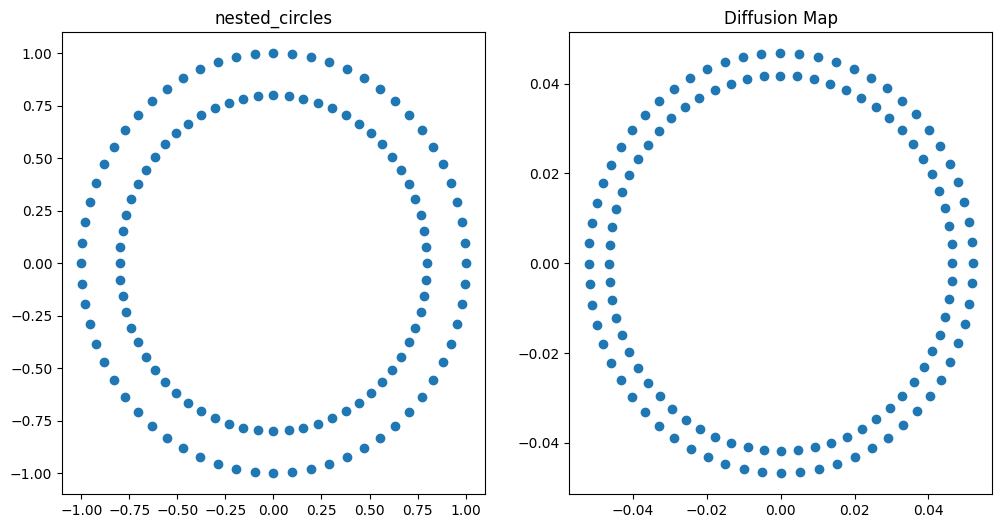

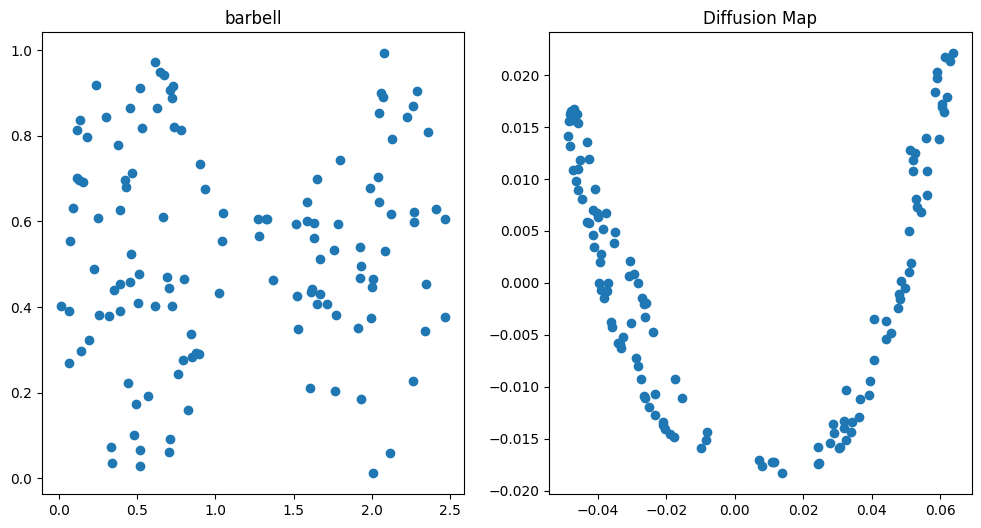

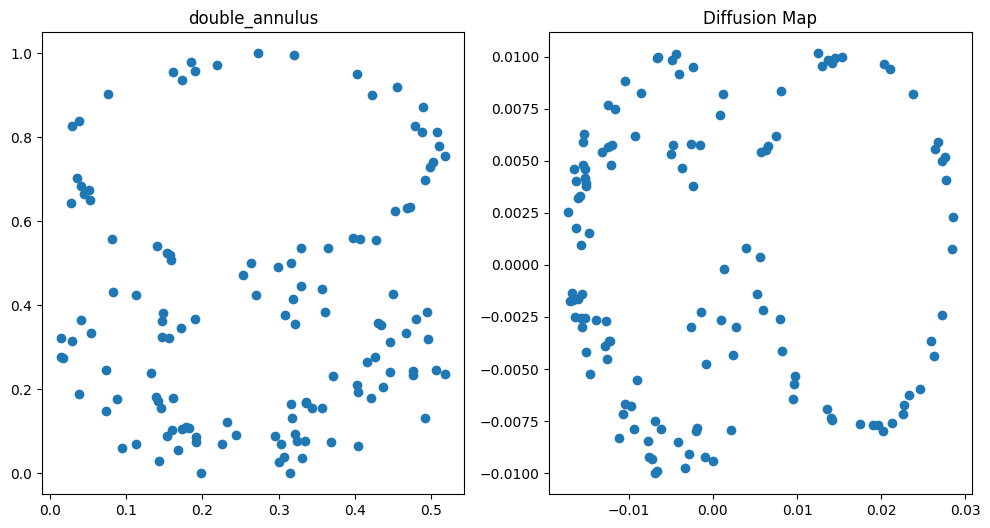

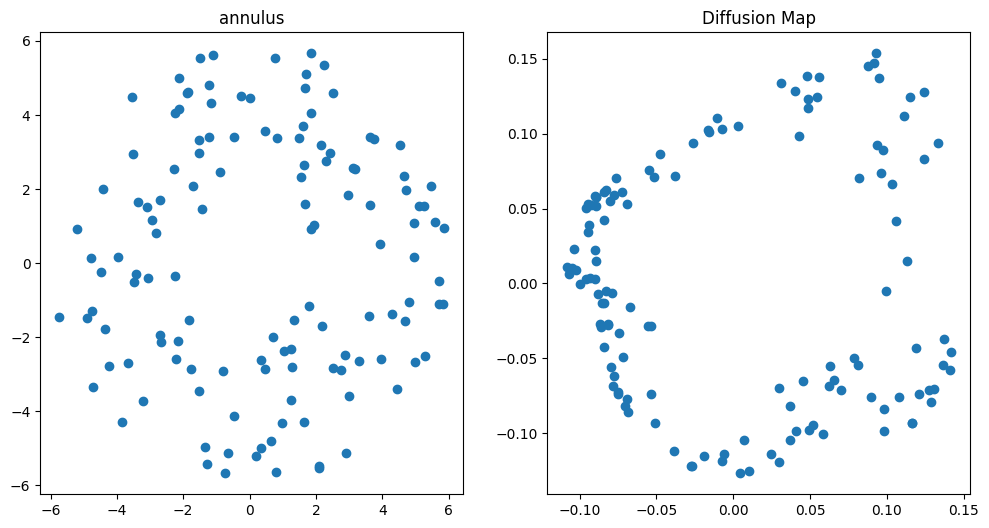

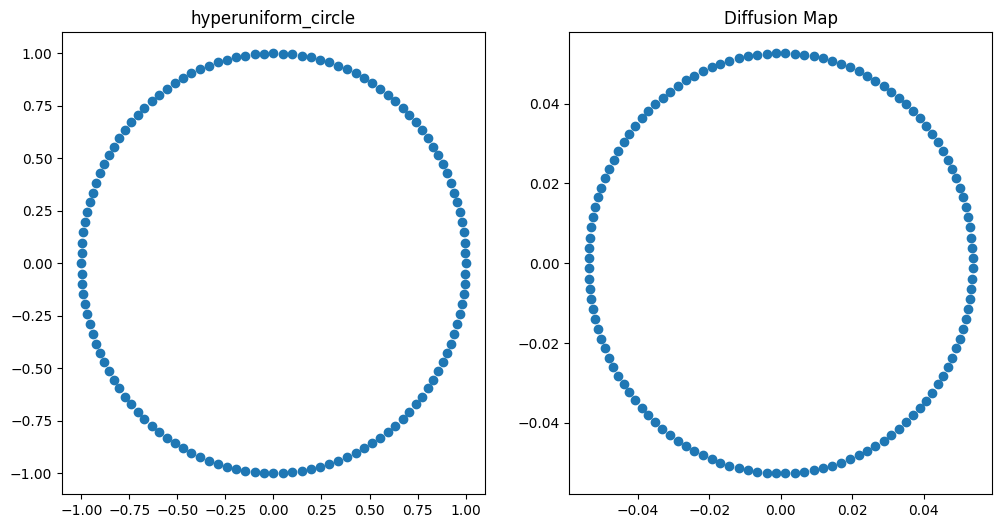

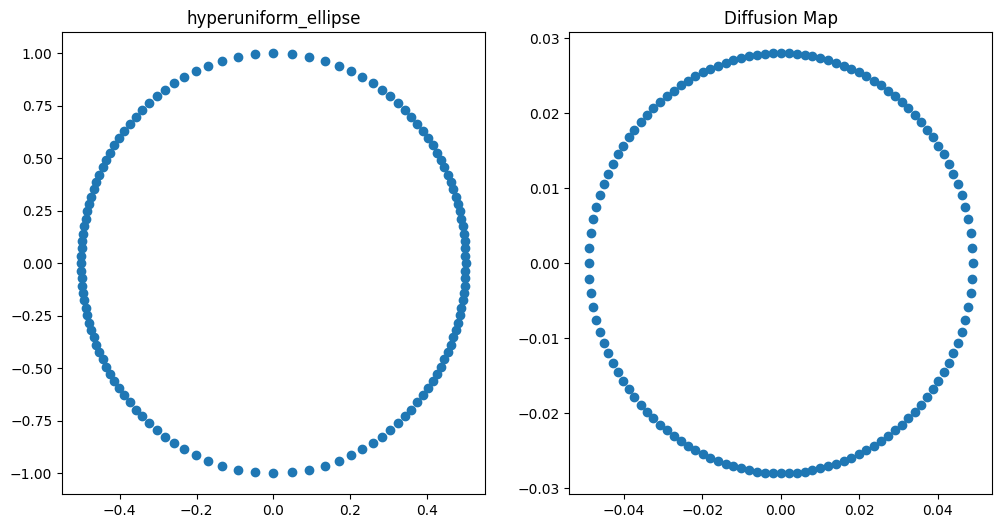

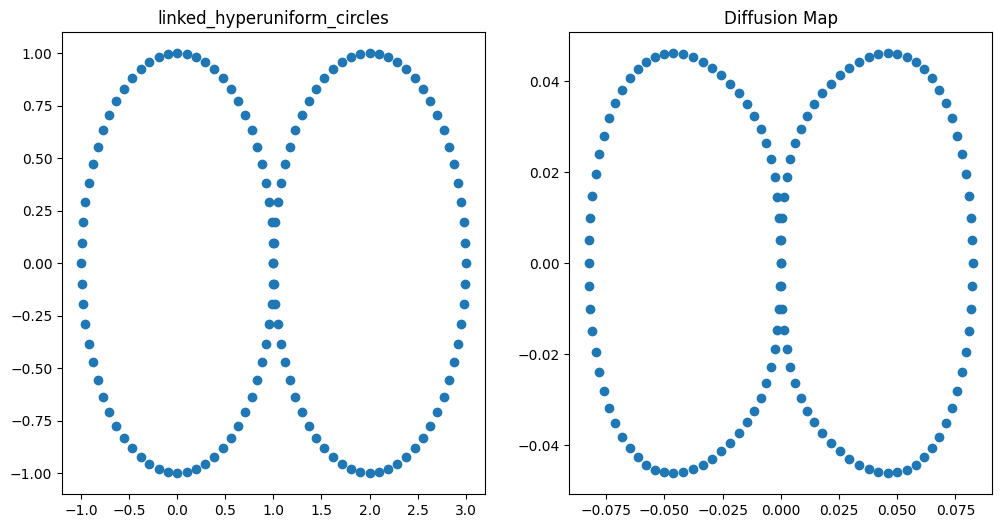

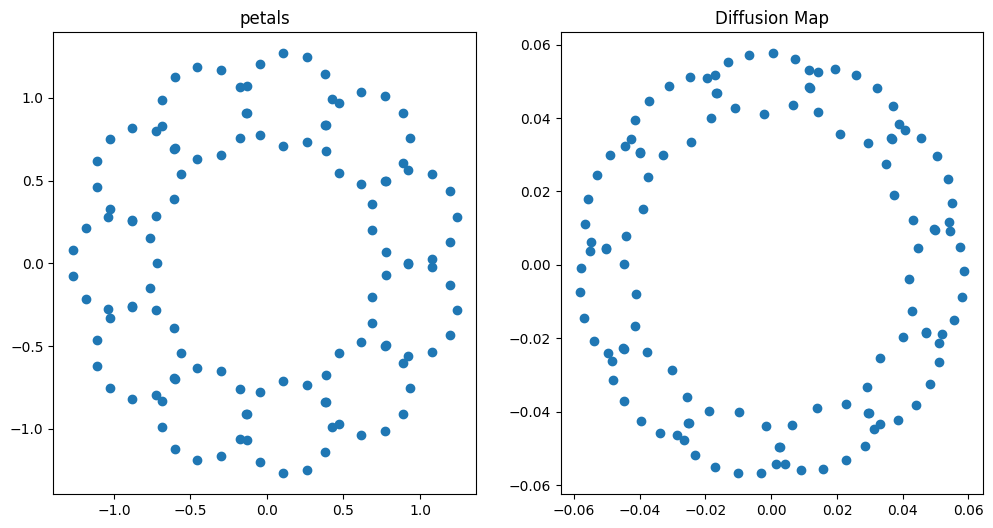

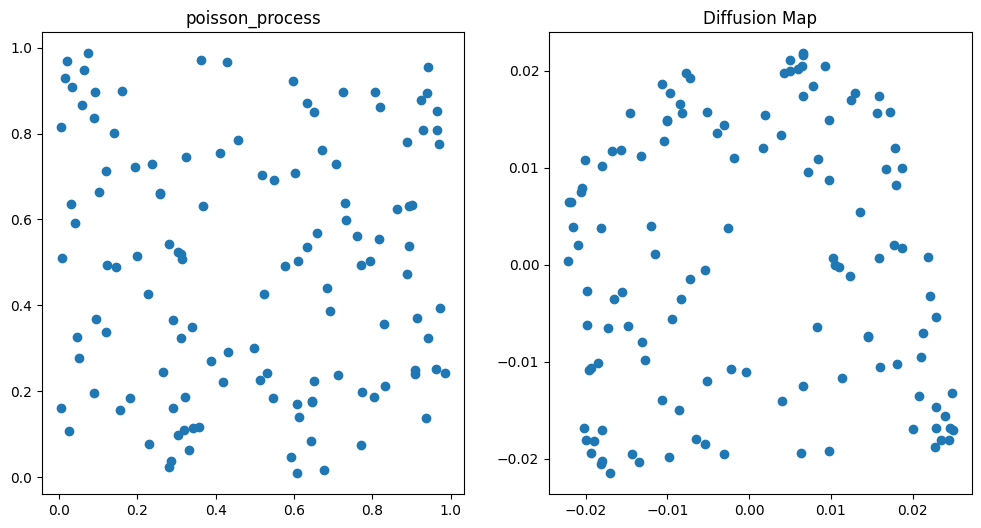

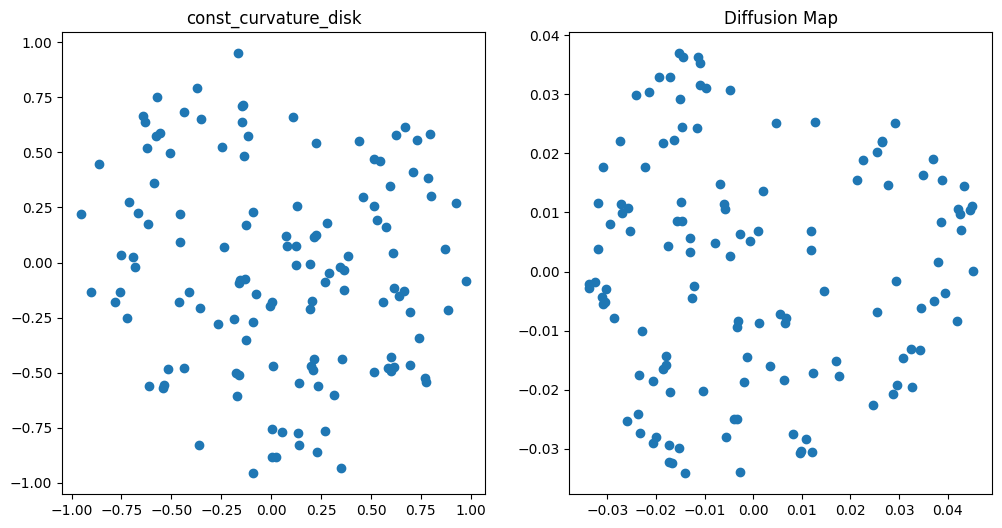

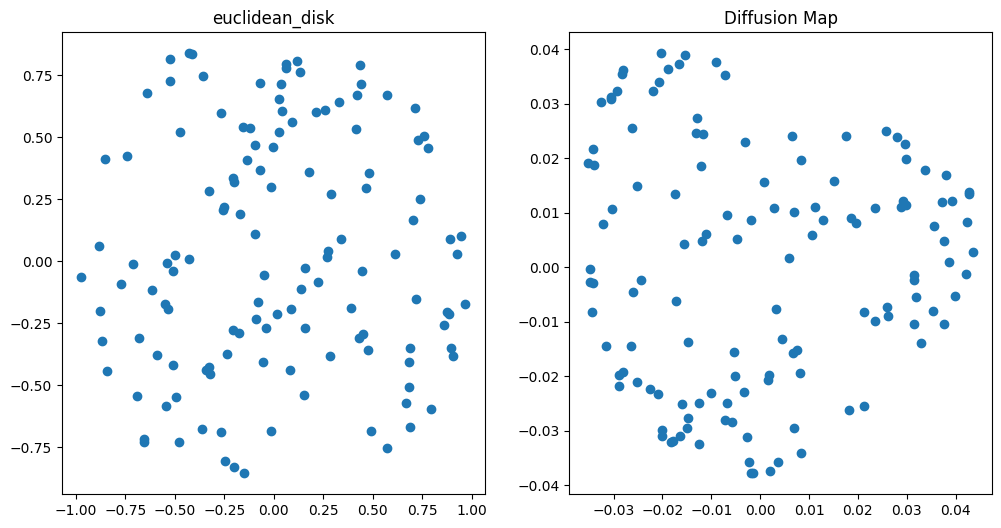

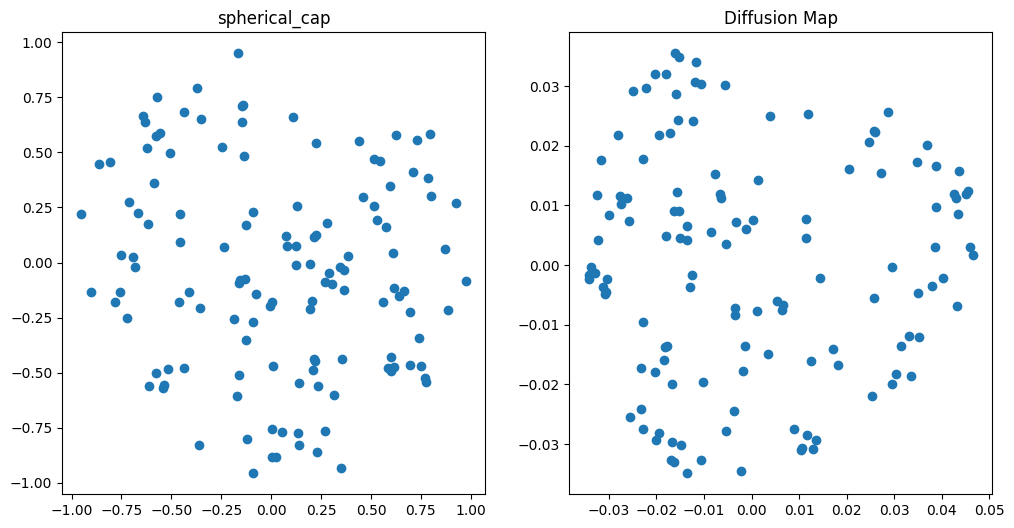

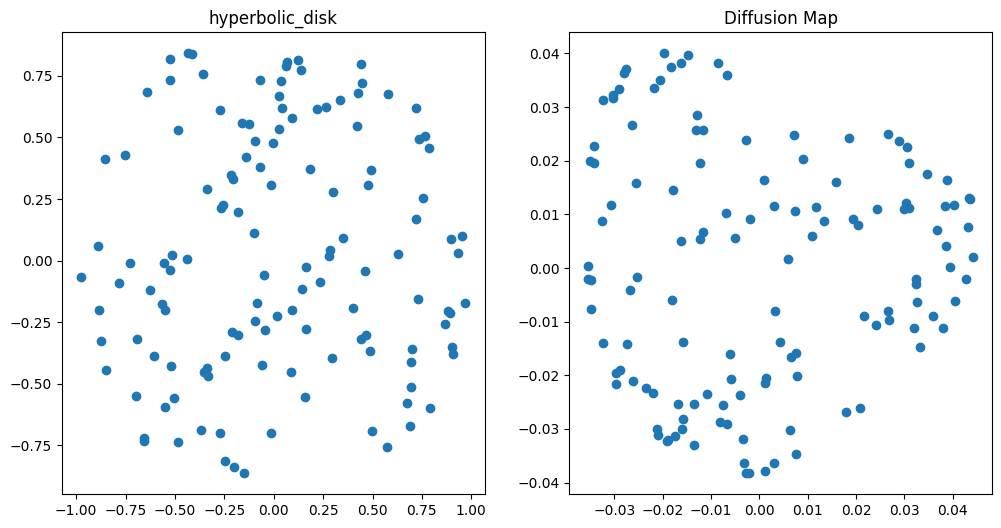

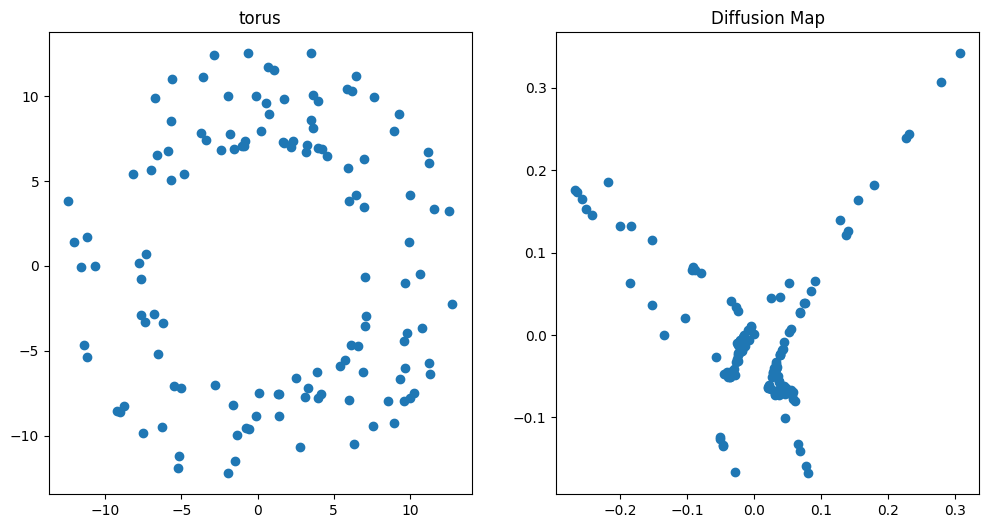

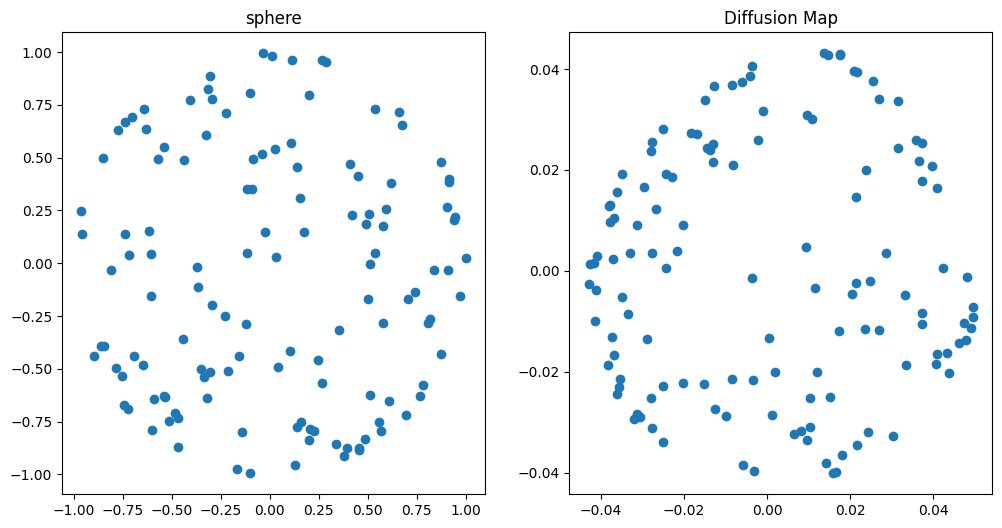

In [118]:
datasets = (spiral, blobs, moons, nested_circles, barbell, double_annulus, annulus, hyperuniform_circle, hyperuniform_ellipse, linked_hyperuniform_circles, petals, poisson_process, const_curvature_disk, euclidean_disk, spherical_cap, hyperbolic_disk, torus, sphere)
for dataset in datasets:
    if dataset.__name__ in ['spherical_cap', 'const_curvature_disk']:
        X, _ = dataset(128, K=2)
    elif dataset.__name__ == 'hyperbolic_disk':
        X, _ = dataset(128, random_state=42, K=-1)
    elif dataset.__name__ == "annulus":
        X, _ = dataset(128, random_state=42, r=2, R=6)
    elif dataset.__name__ in ['torus', 'sphere']:
        X, _ = dataset(128)
    else:
        X, _ = dataset(128, random_state=42)
    P = make_diffusion(X, alpha=1, epsilon=1)
    visuallize_diffusion_map(X, P, name=dataset.__name__)

In [8]:
from utilities import estimate_epsilon

0.10937947449974397


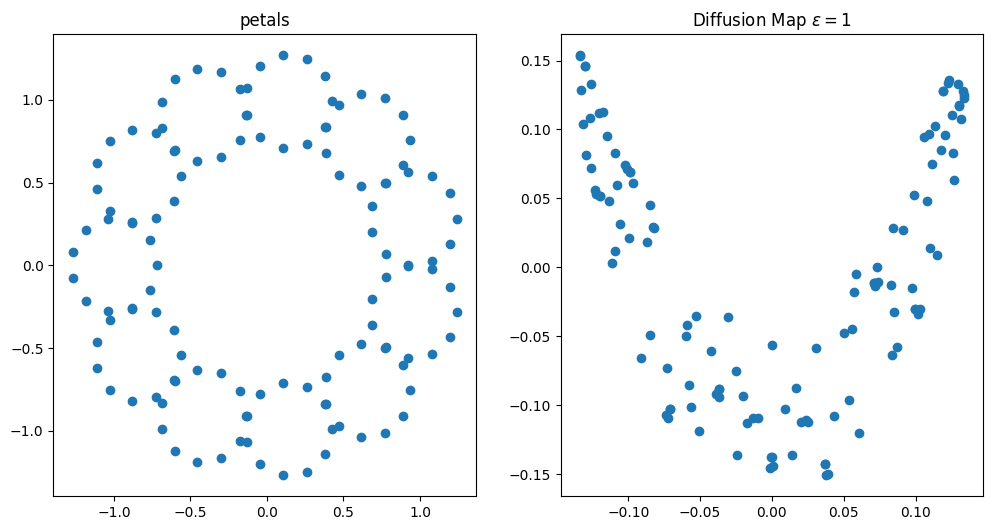

In [11]:
X, _ = petals(128)
epsilon = estimate_epsilon(X)
print(epsilon)
P = make_diffusion(X, alpha=2, epsilon=epsilon)
visuallize_diffusion_map(X, P, name='petals')

0.05


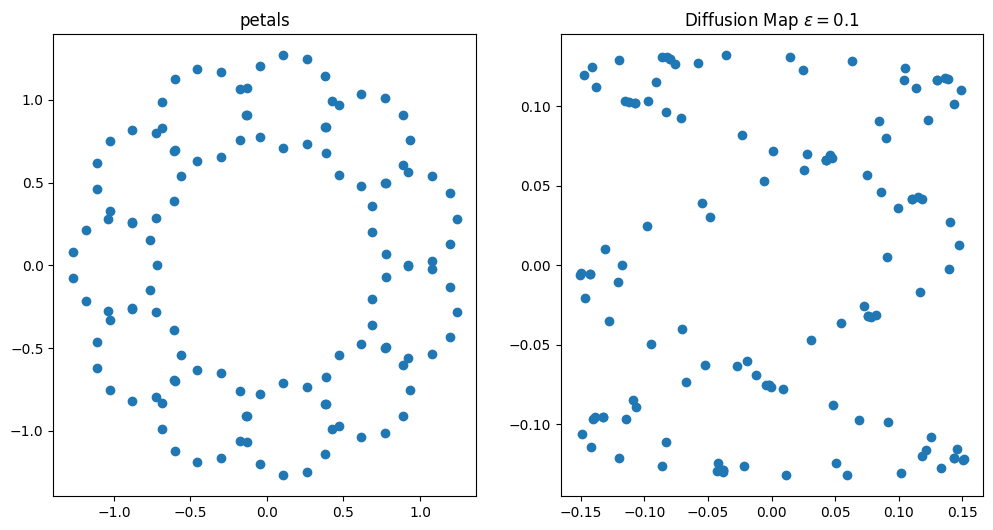

0.05


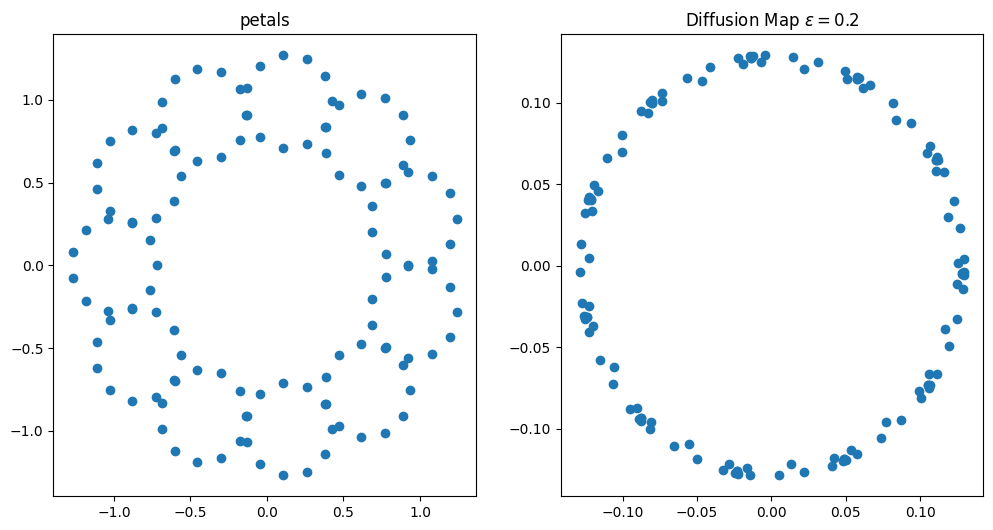

0.05


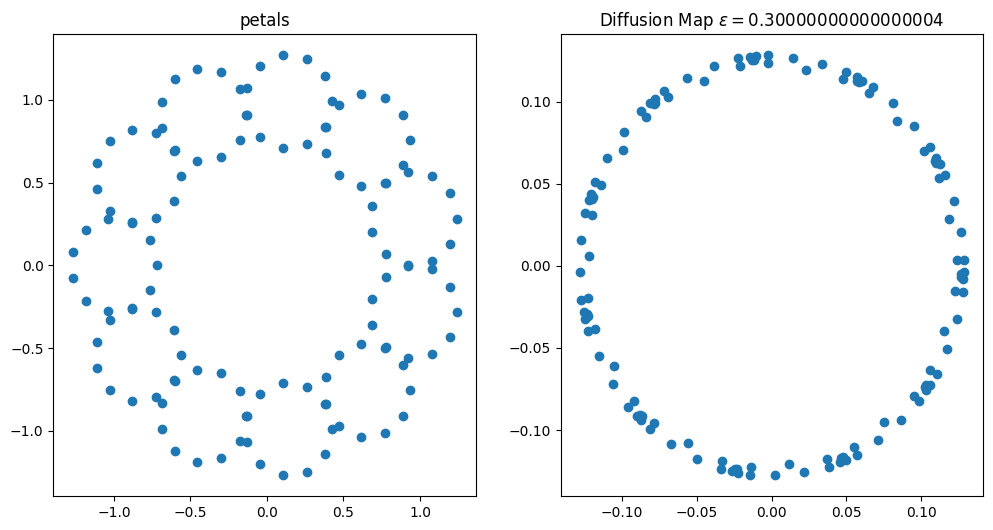

0.05


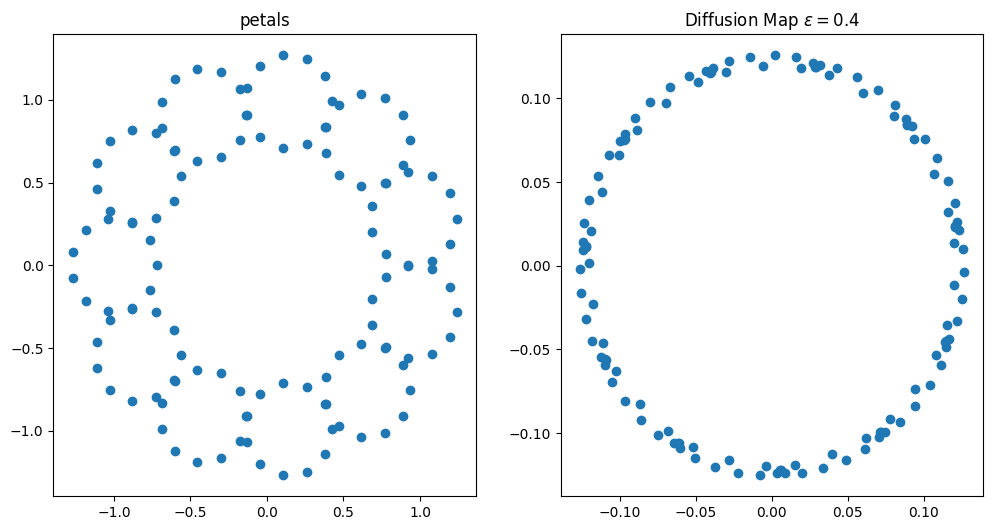

0.05


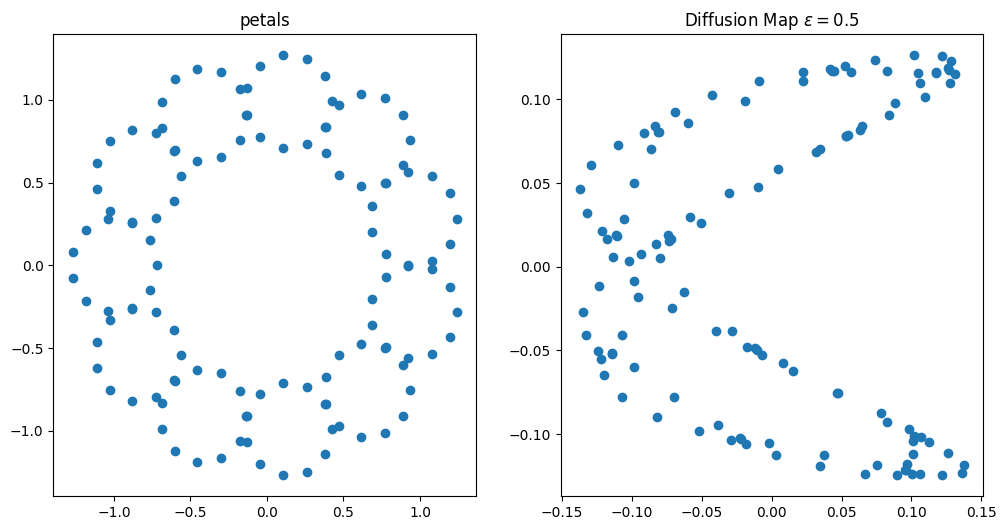

0.05


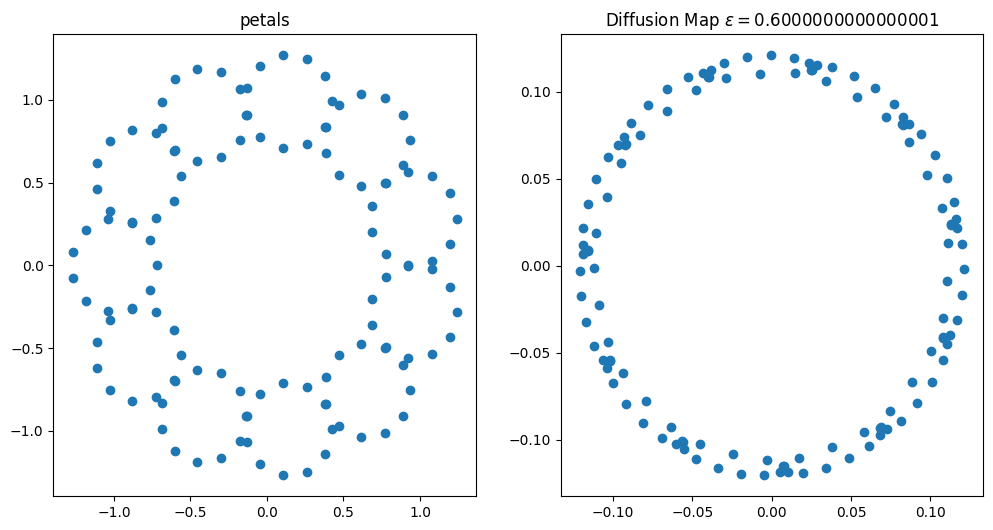

0.05


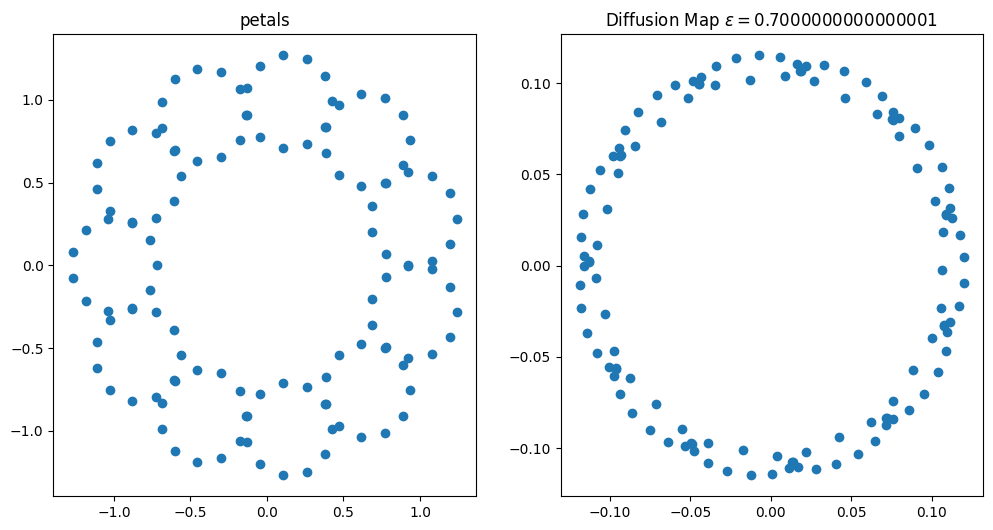

0.05


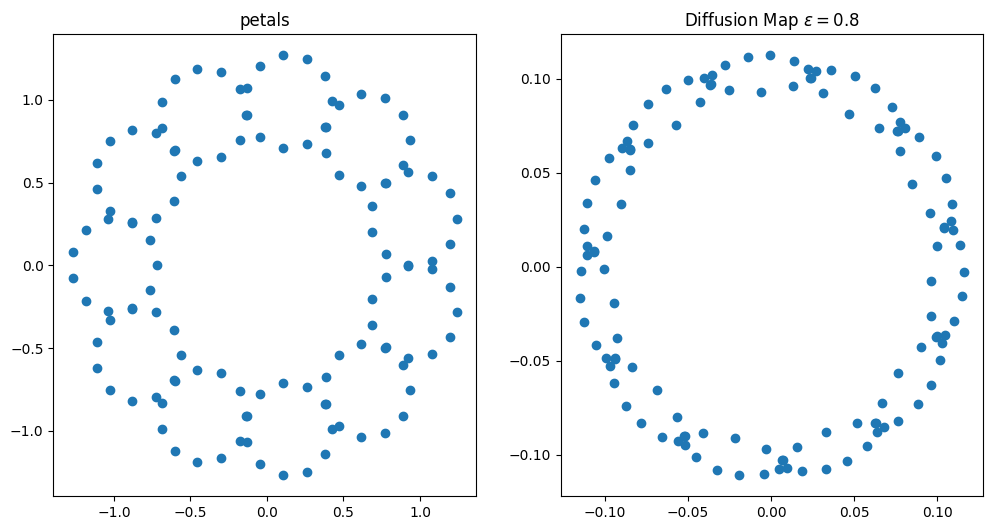

0.05


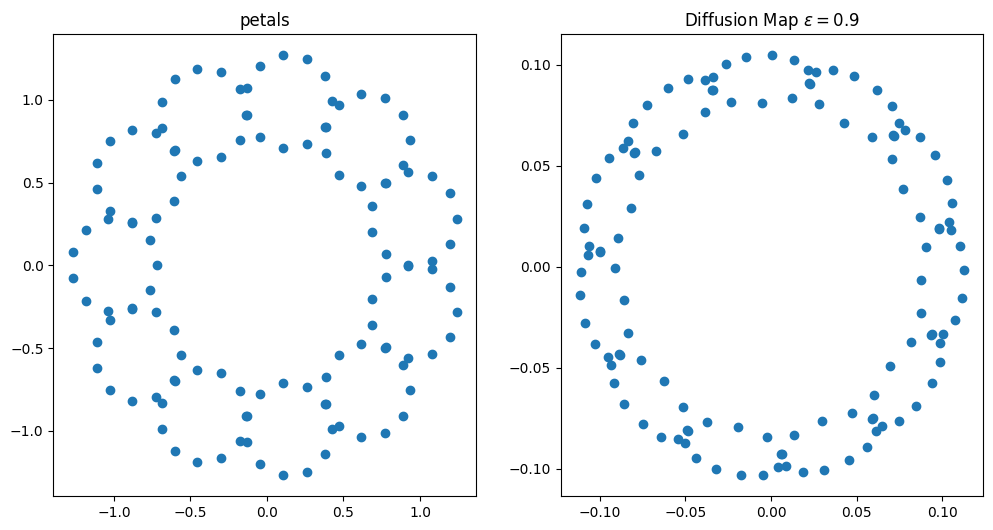

0.05


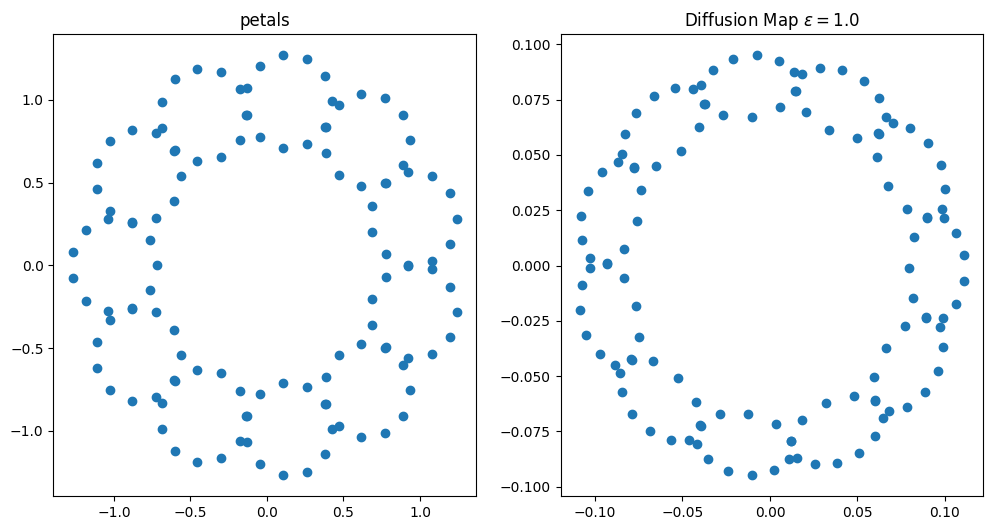

0.05


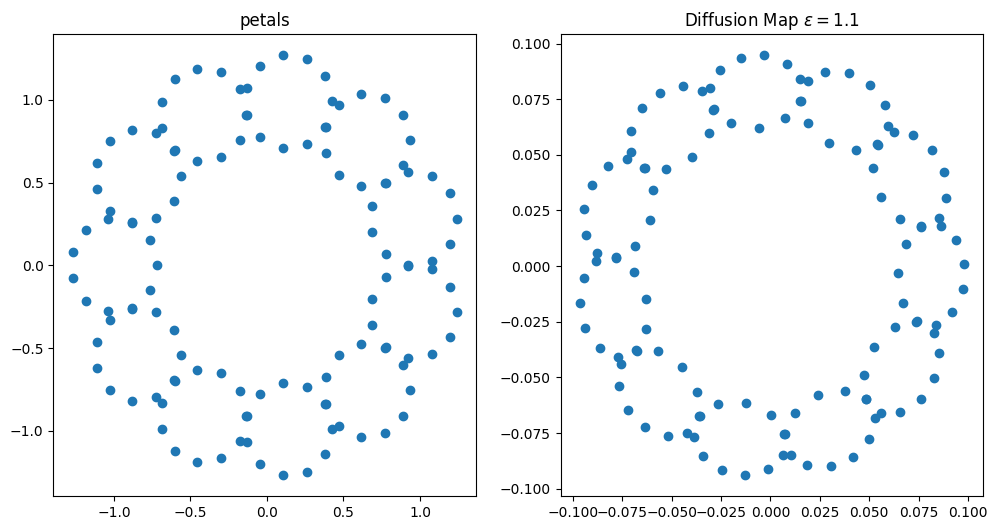

0.05


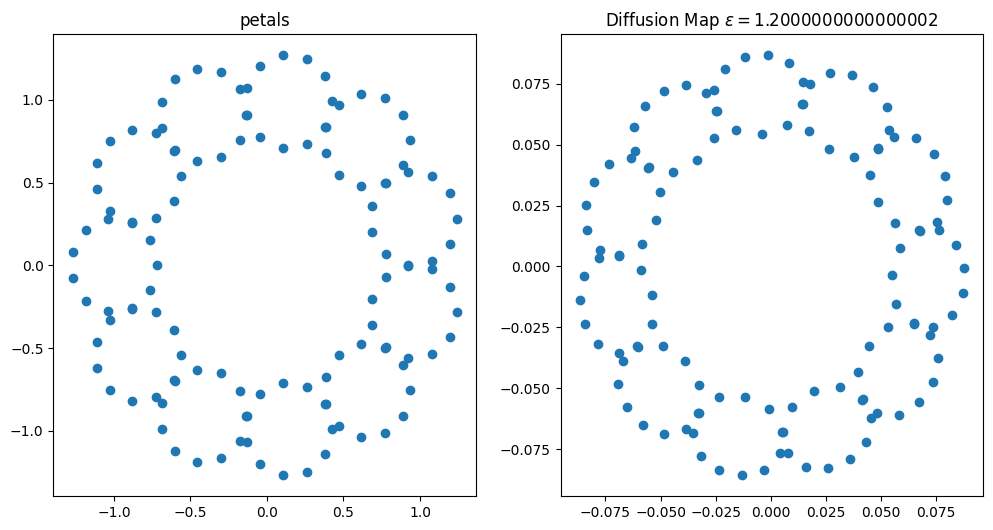

0.05


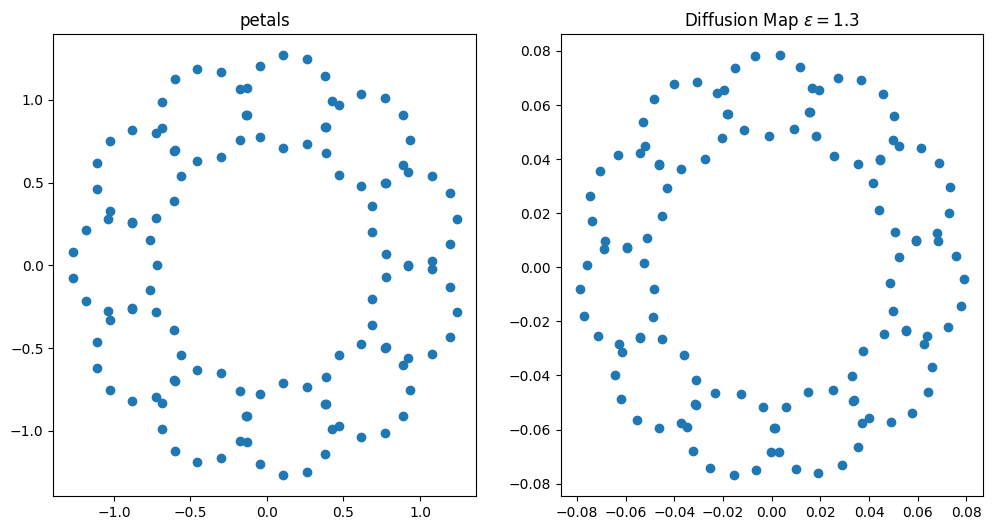

0.05


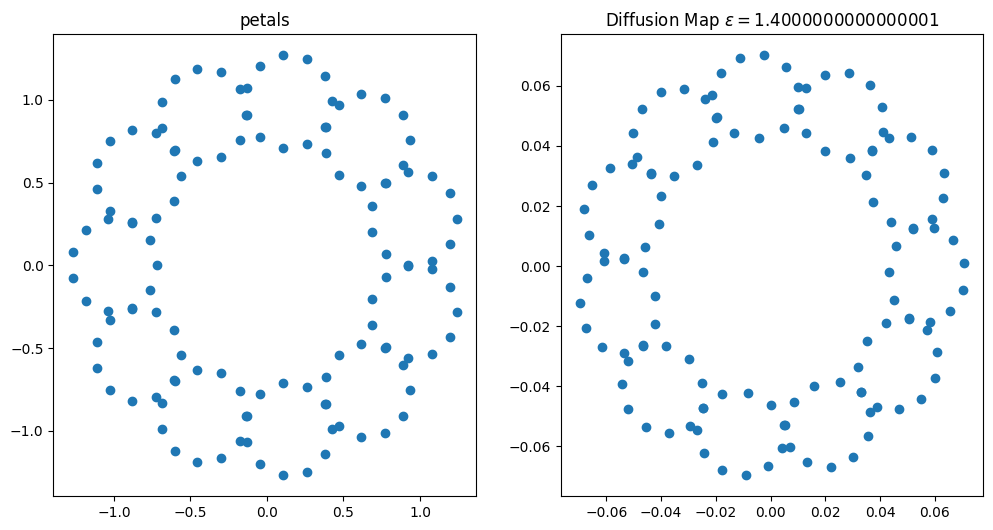

0.05


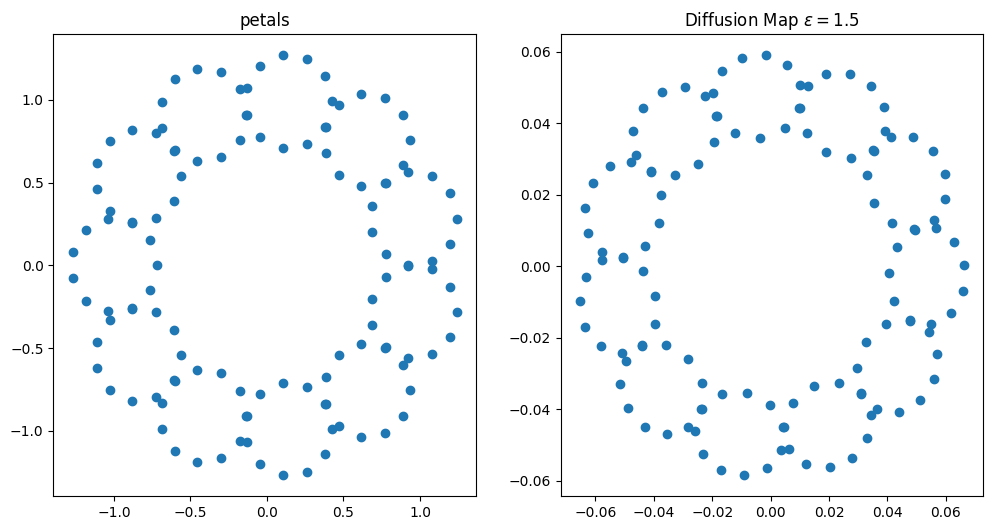

0.05


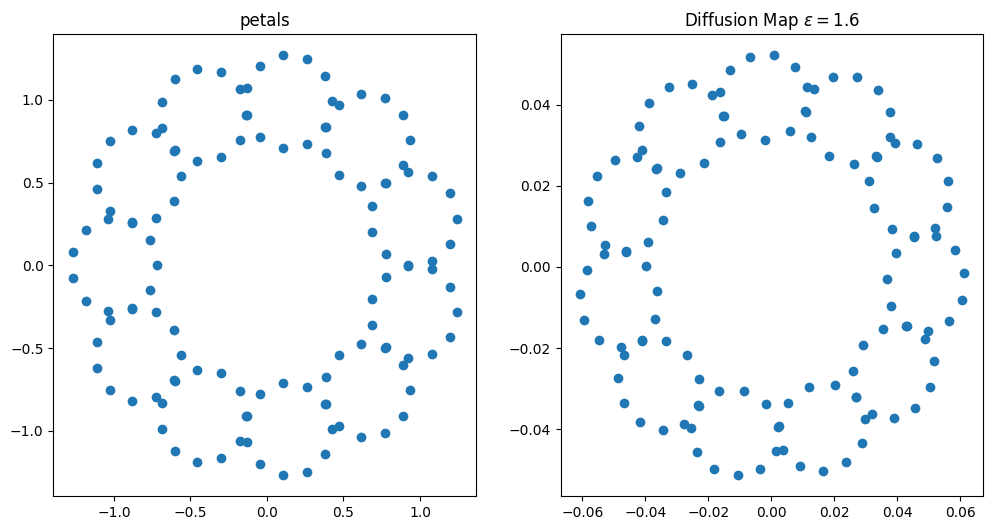

0.05


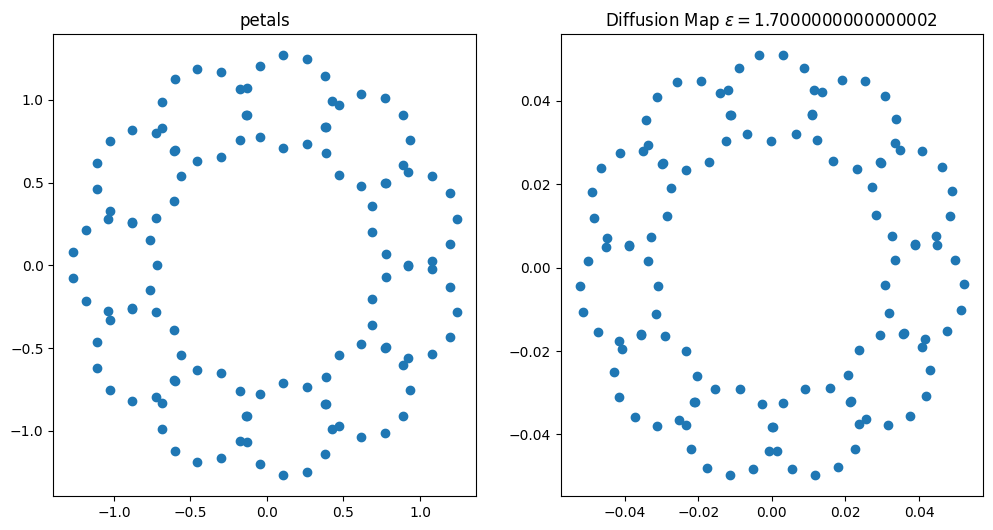

0.05


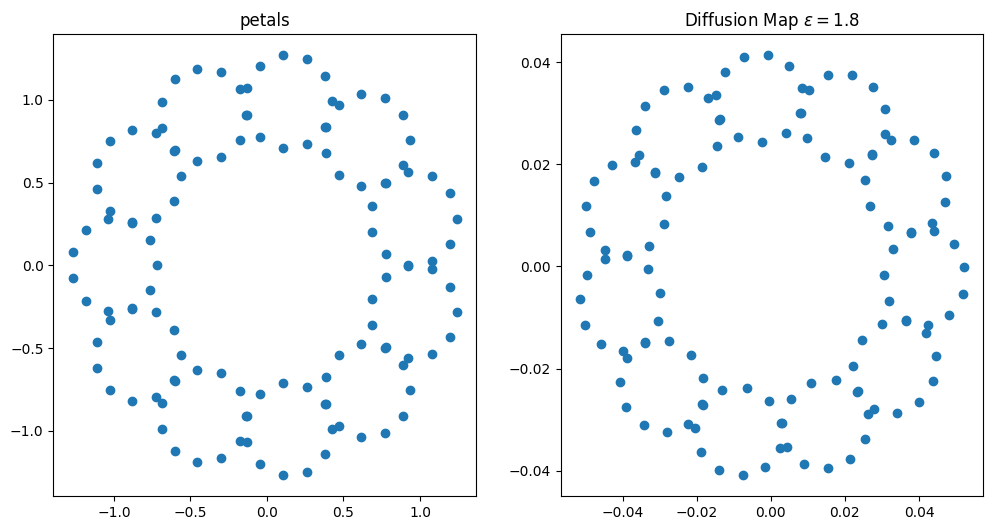

0.05


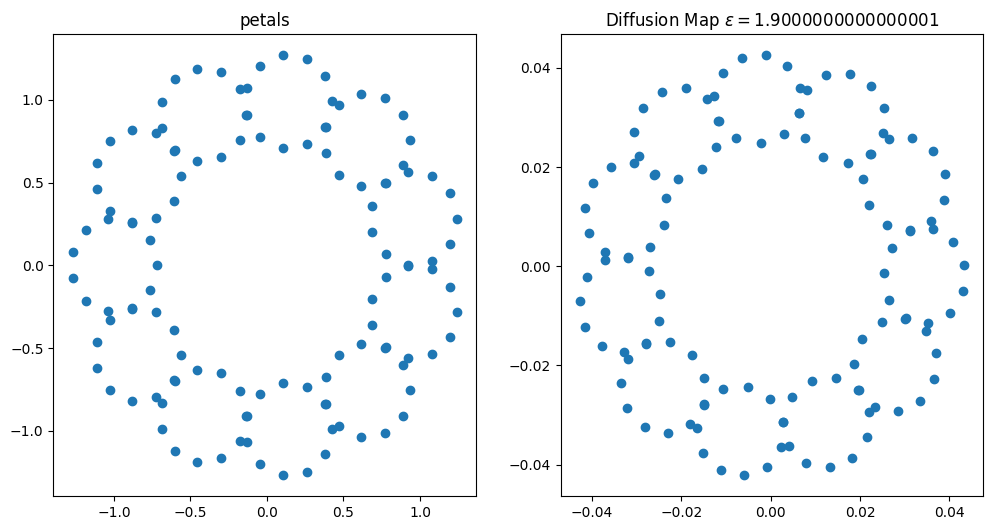

In [19]:
def make_diffusion(X, alpha=1, epsilon=1, threshold=0.05):
    K = alpha_decaying_kernel(X, alpha=alpha, epsilon=epsilon)
    kthr = K.max() * threshold
    K[K<threshold] = 0.
    Q = np.sum(K, axis=1)
    P = np.diag(1.0 / Q) @ K
    return P
for epsilon in np.arange(1, 20) * 0.1:
    X, _ = petals(128)
    P = make_diffusion(X, alpha=2, epsilon=epsilon)
    visuallize_diffusion_map(X, P, name='petals', epsilon=epsilon)

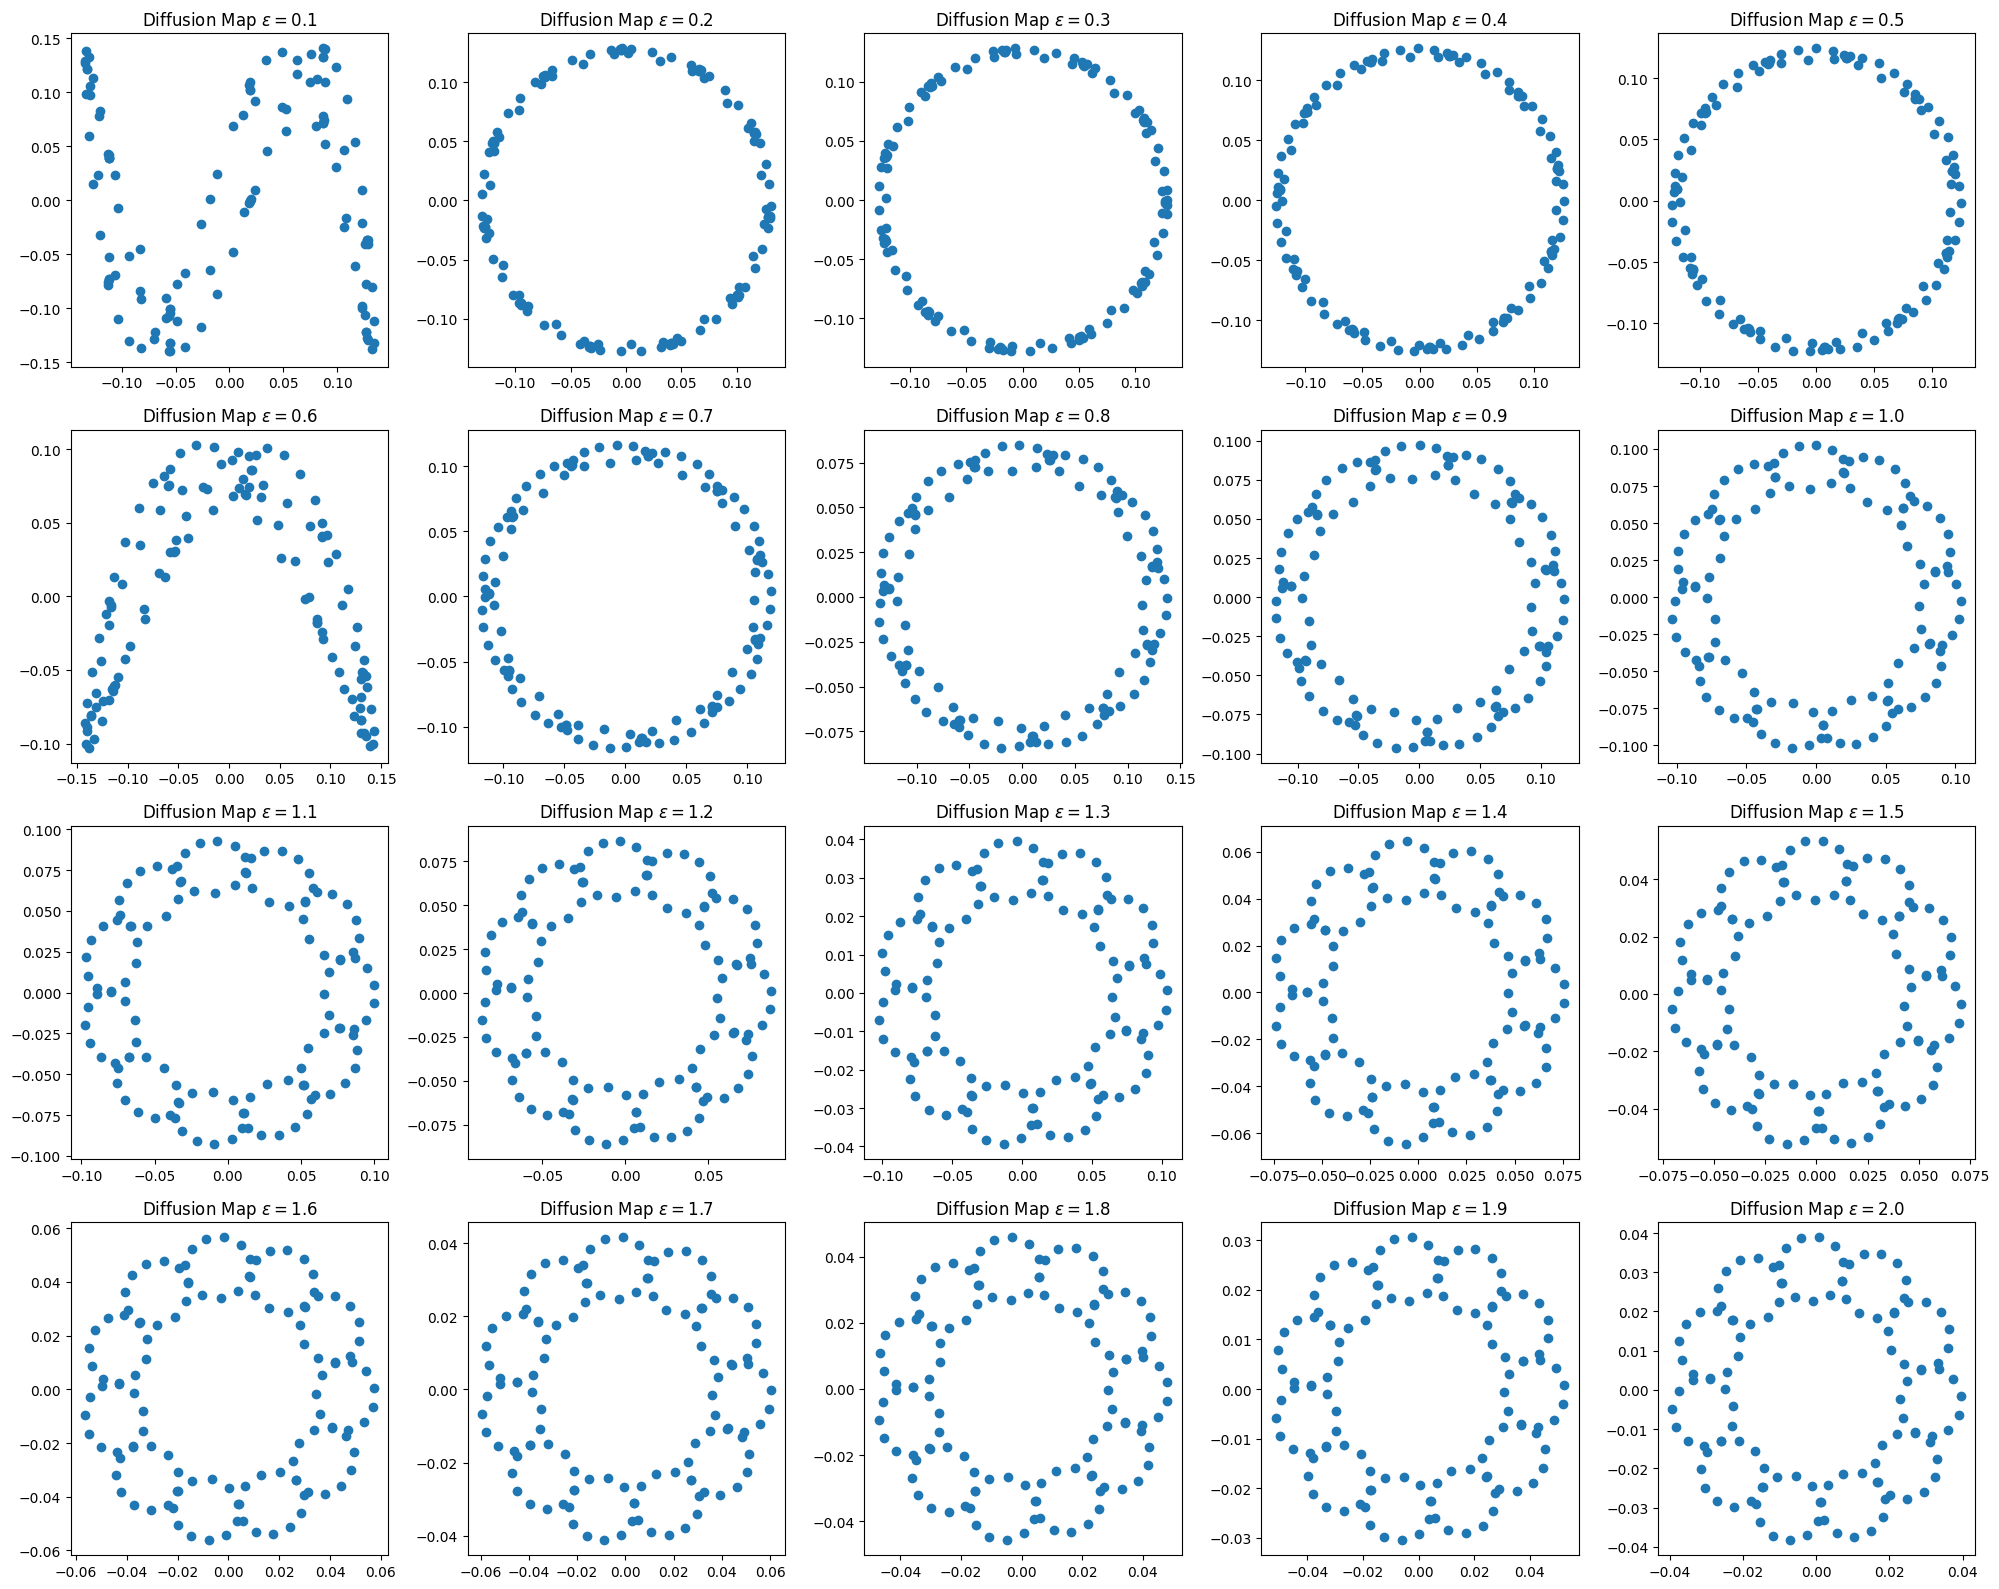

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def make_diffusion(X, alpha=1, epsilon=1, threshold=0.05):
    K = alpha_decaying_kernel(X, alpha=alpha, epsilon=epsilon)
    kthr = K.max() * threshold
    K[K < threshold] = 0.
    Q = np.sum(K, axis=1)
    P = np.diag(1.0 / Q) @ K
    return P

def visuallize_diffusion_map_subplot(X, P, ax, dim=10, tolerance=1e-10, name='Dataset', epsilon=1):
    lam, Xd = diffusion_map(P)  # Assuming diffusion_map is a function you've defined
    Xd = lam * Xd
    pca = PCA(n_components=2)
    Xpca = pca.fit_transform(Xd)

    # Plot the diffusion map on the specified subplot
    ax.scatter(Xpca[:, 0], Xpca[:, 1])
    ax.set_title(f'Diffusion Map $\epsilon={np.round(epsilon, 1)}$')


# Create a 4x5 grid of subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

epsilons = np.arange(1, 21) * 0.1

# Assuming petals is a function that you've defined to generate data
for i, epsilon in enumerate(epsilons):
    row = i // 5  # Integer division to get row index
    col = i % 5   # Remainder to get column index
    X, _ = petals(128)
    P = make_diffusion(X, alpha=2, epsilon=epsilon)
    visuallize_diffusion_map_subplot(X, P, ax=axes[row, col], name='petals', epsilon=epsilon)

plt.tight_layout()
plt.show()
